# Image orientation classification using ResNet50 model
* create-->fit-->validate(test dataset)-->estimate(true data)-->describe-->save results

In [1]:
%load_ext autoreload
%autoreload 2


In [ ]:
# Imports for visualizations
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import os
import json

#
from tensorflow.keras.optimizers import Adam
import tensorflow as tf
from tensorflow.keras.applications import ResNet50 # 50 layers/ requires images to be 224x224 in RGB 
from tensorflow.keras.models import Sequential


# Imports for building the model
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import MaxPooling2D
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dropout

# Imports for image transformations
from tensorflow.keras.layers import Rescaling
from tensorflow.keras.layers import Resizing
#from tensorflow.keras.layers import RandomFlip
from tensorflow.keras.layers import RandomZoom
from tensorflow.keras.layers import RandomRotation
from tensorflow.keras.layers import RandomBrightness
from tensorflow.keras.layers import RandomContrast 
from tensorflow.keras.layers import RandomTranslation

# Importing the image_dataset_from_directory utility from Keras enables parallel processing
from keras.utils import image_dataset_from_directory

# Define global parameter settings
1. Define parameters for image_dataset_from_directory
2. Specify model prefix (to prepend all model related file names) and directory for storing model related data (<model name>.keras)
3. Specify compilation parameters for the model
4. Test dataset description

In [3]:
# 1. parameters for image_dataset_from_directory
param_set = {
    "directory" : r"C:\Users\User\DataScience\area51\data_224x224",
    "batch_size" : 64,
    "seed": 1,
    "label_mode": "categorical",
    "color_mode": "rgb",      # resNet requires 3 channel otherwise needs to be trained from scratch 
    "image_size": (224, 224), # img_height, img_width
    "shuffle": True,
    "validation_split": 0.2,
    "labels": "inferred"  #from folder structure
}

# 2. Model prefix and directory

model_prefix = "resnet50_1" #model folder
model_dir = rf"C:\Users\User\DataScience\area51\models\resnet\{model_prefix}"

# 3. Compilation parameters

compiling_params = {
    "optimizer": 'adam',
     "loss": "categorical_crossentropy", #loss function
     "metrics": ['accuracy']
}

test_dataset_desc = r'''
test dataset dir: "C:\Users\User\DataScience\area51\data_224x224\224x224_test" 

dataset contains images:

    # rotation    :       image count
    # 0°          :       12
    # +90         :       13
    # -90         :       13
    # 180°        :       14


'''



# Prepariing train/validation datasets

In [ ]:

"""
1. Real-time Data Loading with image_dataset_from_directory

    * Reads images directly from folders in batches.
    * Useful when datasets don't fit entirely into memory.
    * --> Automatically assigns labels based on folder structure.
    * process parallelization
    
data_224x224/
├── 224x224_rotated_0/
│   ├── image1.png
│   ├── image2.png
│   └── ...
└── 224x224_rotated_90/
    ├── image101.png
    ├── image102.png
    └── ...
    ...

"""
train_ds = image_dataset_from_directory(subset="training",  **param_set)

val_ds = image_dataset_from_directory(subset="validation", **param_set)

# Number of batches in the training dataset
print("Number of batches in train_ds:", train_ds.cardinality().numpy())

# Number of batches in the validation dataset
print("Number of batches in val_ds:", val_ds.cardinality().numpy())

"\n1. Real-time Data Loading with image_dataset_from_directory\n\n    * Reads images directly from folders in batches.\n    * Useful when datasets don't fit entirely into memory.\n    * --> Automatically assigns labels based on folder structure.\n    * process parallelization\n\ndata_224x224/\n├── 224x224_rotated_0/\n│   ├── image1.png\n│   ├── image2.png\n│   └── ...\n└── 224x224_rotated_90/\n    ├── image101.png\n    ├── image102.png\n    └── ...\n    ...\n\n"

In [17]:
# check label encoding (y-part) -> take first batch
for x, y in train_ds.take(1):
    print("x Sample shape:", x.shape) # x Sample shape: (batches, img_height, img_width, color_channels)  
    print("x Sample values:", x.numpy()[0:1][0:1][:1])
    print("y Sample shape:", y.shape) # batch size -> rows, classes count --> columns 
    print("y Sample values:", y.numpy()[:4])
    break

x Sample shape: (64, 224, 224, 3)
x Sample values: [[[[ 37.  37.  37.]
   [ 62.  62.  62.]
   [ 73.  73.  73.]
   ...
   [  6.   6.   6.]
   [  6.   6.   6.]
   [  6.   6.   6.]]

  [[ 26.  26.  26.]
   [ 43.  43.  43.]
   [ 52.  52.  52.]
   ...
   [  6.   6.   6.]
   [  6.   6.   6.]
   [  6.   6.   6.]]

  [[ 24.  24.  24.]
   [ 35.  35.  35.]
   [ 40.  40.  40.]
   ...
   [  6.   6.   6.]
   [  6.   6.   6.]
   [  6.   6.   6.]]

  ...

  [[ 79.  79.  79.]
   [115. 115. 115.]
   [124. 124. 124.]
   ...
   [ 99.  99.  99.]
   [ 96.  96.  96.]
   [ 78.  78.  78.]]

  [[ 80.  80.  80.]
   [117. 117. 117.]
   [125. 125. 125.]
   ...
   [ 99.  99.  99.]
   [ 98.  98.  98.]
   [ 80.  80.  80.]]

  [[ 61.  61.  61.]
   [ 90.  90.  90.]
   [ 94.  94.  94.]
   ...
   [ 69.  69.  69.]
   [ 70.  70.  70.]
   [ 59.  59.  59.]]]]
y Sample shape: (64, 4)
y Sample values: [[0. 0. 1. 0.]
 [0. 1. 0. 0.]
 [1. 0. 0. 0.]
 [0. 1. 0. 0.]]


# Preprocess train/validation data to allign with data the resNet50 was trained on--> ImageNet dataset

When you apply preprocess_input(image_tensor), it does:

✅ 1. Converts RGB → BGR (channel order switch)

    ResNet50 was trained using images in BGR format (from original Caffe implementation).

    So it swaps the channels from [R, G, B] → [B, G, R].

✅ 2. Subtracts the ImageNet mean pixel values (no scaling to [0, 1]!)

    It subtracts these values per channel:

        Blue: 103.939

        Green: 116.779

        Red: 123.68

This centers the data around zero, similar to how the original model was trained.

In [18]:
# Before using a pre-trained model like **ResNet**, it is essential to ensure that the **new input data** undergoes the 
# **same preprocessing** as was applied to the original dataset # (**ImageNet**) when the model was trained. 
# This ensures **compatibility** between our data and the pre-trained model

from tensorflow.keras.applications.resnet50 import preprocess_input

# One-hot encoded labels [1000, 0100, 0010, 0001, ...] len([...])=batch_size
train_ds = train_ds.map(lambda x, y: (preprocess_input(x), y))
val_ds = val_ds.map(lambda x, y: (preprocess_input(x), y))

# Determine what loss function to use

<table data-start="919" data-end="1256" node="[object Object]"><thead data-start="919" data-end="995"><tr data-start="919" data-end="995"><th data-start="919" data-end="935">Loss Function</th><th data-start="935" data-end="960">Label Format</th><th data-start="960" data-end="974">Num Classes</th><th data-start="974" data-end="995">Example Label</th></tr></thead><tbody data-start="1073" data-end="1256"><tr data-start="1073" data-end="1162"><td><code data-start="1075" data-end="1101">categorical_crossentropy</code></td><td>One-hot encoded</td><td><code data-start="1130" data-end="1133">n</code></td><td><code data-start="1144" data-end="1158">[0, 1, 0, 0]</code></td></tr><tr data-start="1163" data-end="1256"><td><code data-start="1165" data-end="1198">sparse_categorical_crossentropy</code></td><td>Integer class indices</td><td><code data-start="1225" data-end="1228">n</code></td><td><code data-start="1239" data-end="1242">2</code></td></tr></tbody></table>

In [20]:
# To verify your image shape inside the dataset pipeline, you can print one:
# check label encoding -> take first batch
for x, y in train_ds.take(1):
    print("x Sample shape:", x.shape) # x Sample shape: (batches, img_height, img_width, color_channels)  
    print("x Sample values:", x.numpy()[0:1][0:1][:1])
    print("y Sample shape:", y.shape) # batch size -> rows, classes count --> columns 
    print("y Sample values:", y.numpy()[:4])
    break


x Sample shape: (64, 224, 224, 3)
x Sample values: [[[[-103.939 -116.779 -123.68 ]
   [-103.939 -116.779 -123.68 ]
   [-103.939 -116.779 -123.68 ]
   ...
   [ -99.939 -112.779 -119.68 ]
   [ -99.939 -112.779 -119.68 ]
   [ -99.939 -112.779 -119.68 ]]

  [[-103.939 -116.779 -123.68 ]
   [-103.939 -116.779 -123.68 ]
   [-103.939 -116.779 -123.68 ]
   ...
   [ -97.939 -110.779 -117.68 ]
   [ -97.939 -110.779 -117.68 ]
   [ -97.939 -110.779 -117.68 ]]

  [[-103.939 -116.779 -123.68 ]
   [-103.939 -116.779 -123.68 ]
   [-103.939 -116.779 -123.68 ]
   ...
   [ -97.939 -110.779 -117.68 ]
   [ -97.939 -110.779 -117.68 ]
   [ -97.939 -110.779 -117.68 ]]

  ...

  [[-103.939 -116.779 -123.68 ]
   [-103.939 -116.779 -123.68 ]
   [-103.939 -116.779 -123.68 ]
   ...
   [ -98.939 -111.779 -118.68 ]
   [ -97.939 -110.779 -117.68 ]
   [ -97.939 -110.779 -117.68 ]]

  [[-103.939 -116.779 -123.68 ]
   [-103.939 -116.779 -123.68 ]
   [-103.939 -116.779 -123.68 ]
   ...
   [-101.939 -114.779 -121.68 ]
   

# Model definition & compilation

In [10]:
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.layers import Dense, Flatten, Input
from tensorflow.keras.models import Model
import tensorflow as tf

# Model creation using the Functional API
inputs = Input(shape=(224, 224, 3))

base_model = ResNet50(weights='imagenet', include_top=False, input_tensor=inputs)

# freeze the model's layers
base_model.trainable = False

# Apply augmentations
x = RandomRotation(0.1)(inputs)                          
x = RandomTranslation(height_factor=0.1, width_factor=0.1)(x) 
x = RandomZoom(0.1)(x)  
#x = RandomFlip("horizontal")(x)

x = base_model.output
x = Flatten()(x)
predictions = Dense(4, activation='softmax')(x) # 4 classes for orientations: 0°, 90°, 180°, 270°

model = Model(inputs=inputs, outputs=predictions)

# When loading data using image_dataset_from_directory() — labels are automatically integers --> sparse_categorical_crossentropy must be used.
# But after resNet preprocessing: train_ds = train_ds.map(lambda x, y: (preprocess_input(x), y)) the classes are one-hot
# encoded -->  categorical_crossentropy must be used

model.compile(**compiling_params)


# Setting up Callbacks for early stopping of the trainig

In [11]:
# callbacks for early stopping

from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping
from tensorflow.keras.callbacks import Callback
from timeit import default_timer as timer


class TimingCallback(Callback):
    def __init__(self, logs={}):
        self.logs=[]
    def on_epoch_begin(self, epoch, logs={}):
        self.starttime = timer()
    def on_epoch_end(self, epoch, logs={}):
        self.logs.append(timer()-self.starttime)


class StopAtValAccuracy(Callback):
        def __init__(self, target_val_accuracy=0.95):
            super().__init__()
            self.target_val_accuracy = target_val_accuracy

        def on_epoch_end(self, epoch, logs=None):
            val_accuracy = logs.get("val_accuracy")
            if val_accuracy is not None:
                if val_accuracy >= self.target_val_accuracy:
                    print(f"\nReached target validation accuracy of {self.target_val_accuracy*100:.2f}% at epoch {epoch+1}. Stopping training.")
                    self.model.stop_training = True


early_stopping = EarlyStopping(
                                patience=5, # Wait for 5 epochs before applying
                                min_delta=0.01, # If the loss function doesn't change by 1% after 5 epochs, either up or down, we stop
                                verbose=1, # Display the epoch at which training stops
                                mode='min',
                                monitor='val_loss')

reduce_learning_rate = ReduceLROnPlateau(
                                    monitor="val_loss",
                                    patience=3, # If val_loss stagnates for 3 consecutive epochs based on the min_delta value
                                    min_delta=0.01,
                                    factor=0.1,  # Reduce the learning rate by a factor of 0.1
                                    cooldown=4,  # Wait 4 epochs before retrying 
                                    verbose=1)

time_callback = TimingCallback() 

# Training


In [ ]:
target_val_acc = 0.98
stop_at_specified_val_acc = StopAtValAccuracy(target_val_acc)

history_resnet50 = model.fit(train_ds, 
                          epochs=10,
                          validation_data=val_ds,
                          callbacks = [reduce_learning_rate,
                                       early_stopping,
                                       time_callback,
                                       stop_at_specified_val_acc]) 

# Saving results and model

In [ ]:
#-----storing reslts to files: model, dataGenParams, training history------------------------------------------------------------
import os
import json

# Save the model
model_path = os.path.join(model_dir, f'orientation_classifier_{model_prefix}.keras')
model.save(model_path)

# save dataGenParams used
param_path = os.path.join(model_dir, f'param_set_{model_prefix}.json')
with open(param_path, 'w') as f:
    json.dump(param_set, f)

# Save training history: accuracy and loss for each epoch
history_path = os.path.join(model_dir, f'training_history_{model_prefix}.json')
with open(history_path, 'w') as f:
    json.dump(history_resnet50.history, f)

# Loading the trained model
* show model layera parameters and metrics

model summary: resnet50_1


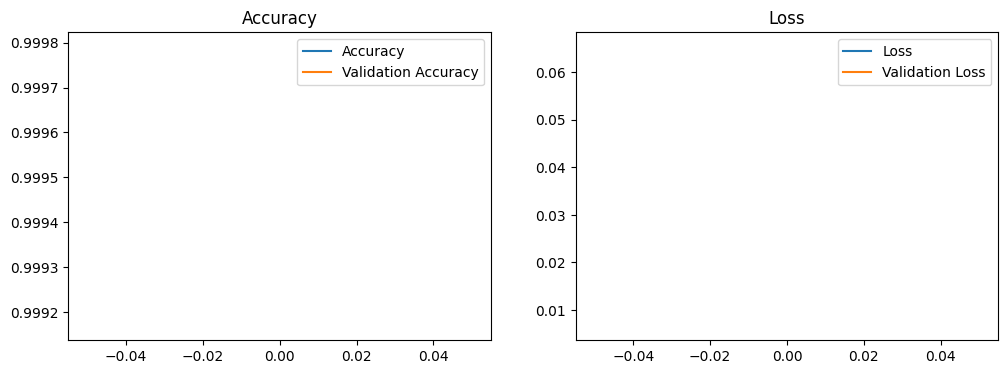

In [6]:
#------loading saved model, dataGenParams, training history
import json, os
import matplotlib.pyplot as plt
from tensorflow.keras.models import load_model

# ----!!!!!----->Load model with correpsonding dataGenParams<-----!!!!!----
model_dir = model_dir

# loading model
model_path = os.path.join(model_dir, f'orientation_classifier_{model_prefix}.keras')
model = load_model(model_path)

# Load training history
history_path = os.path.join(model_dir, f'training_history_{model_prefix}.json')
with open(history_path, 'r') as f:
    history = json.load(f)


#----model summary
print(f"model summary: {model_prefix}")
#model.summary()

# Plot accuracy and loss
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history['accuracy'], label='Accuracy')
plt.plot(history['val_accuracy'], label='Validation Accuracy')
plt.legend()
plt.title('Accuracy')

plt.subplot(1, 2, 2)
plt.plot(history['loss'], label='Loss')
plt.plot(history['val_loss'], label='Validation Loss')
plt.legend()
plt.title('Loss')

plt.show()

## Define prediction function -> apply **preprocess_input()** to data to be predicted

Pretrained models like **ResNet50** expect inputs to be preprocessed exactly the same way as they were during training.

If you skip **preprocess_input()** during prediction:

    The model will receive unnormalized pixel values.

    Your predictions will likely be inaccurate or completely wrong

In [62]:
import pandas as pd
import numpy as np
from src.defs import DiseaseCategory as dc
import tensorflow.keras.models as models
import tensorflow as tf
from tensorflow.keras.applications.resnet50 import preprocess_input
from tensorflow.keras.preprocessing import image 

# Step 1: Define the prediction function

def estimate_orientation(img_path, model):
    
    img = image.load_img(img_path, target_size=(224, 224))          # loads in RGB by default, ResNet50 expects 224x224 in RGB --> Shape: (224, 224, 3)
    img_array = image.img_to_array(img)                             # Convert to array
    img_array = np.expand_dims(img_array, axis=0)                   # Shape becomes (1, 224, 224, 3)
    img_array = preprocess_input(img_array)                         # 🔥 Preprocess -->ready for prediction

    # Get predictions
    prediction = model.predict(img_array)  # Shape: (1, 4)

    # Class index (one-hot vector [0, 0, 1, 0]) mapping from train_generator.class_indices
    index_to_orientation = {
        0: 'rotated_90',       # from folder 
        1: 'rotated_minus_90', # from folder 
        2: 'correct',          # from folder 
        3: 'rotated_180'       # from folder 
    }


    predicted_index = int(np.argmax(prediction[0]))
    confidence = float(prediction[0][predicted_index])
    orientation = index_to_orientation[predicted_index]
    
    return orientation, confidence


# load the model
model_dir = model_dir
model_path = model_path
model = models.load_model(model_path)



# Predict

In [63]:
import pandas as pd
import numpy as np
import os
from src.defs import DiseaseCategory as dc


# Step 3: Predict orientation for all images in the dataset

def estimate_image_orientation(model, dataset):
    # * dataset: "test", "data"

    # * Default: Test dataset with determined rotated images:

    # image_dir = r"C:\Users\User\DataScience\area51\data_224x224\224x224_test" 

    # rotation    :       image count
    # 0°          :       12
    # +90         :       13
    # -90         :       1
    # 180°        :       14

    df = pd.DataFrame(columns=["Image","Orientation","Confidence","Disease"])
    
    results = []
    dis = None

    for disease in dc:

        if dataset == "test":
            image_dir = r"C:\Users\User\DataScience\area51\data_224x224\224x224_test"
            dis = "test_data"

        elif dataset == "data":
            image_dir = rf"C:\Users\User\DataScience\area51\data\COVID-19_Radiography_Dataset\{disease.value}\downscaled\224x224"
            dis = disease.value

        else:
            raise Exception(f"Wrong dataset: {dataset}")        
        
        for img_name in os.listdir(image_dir):
            img_path = os.path.join(image_dir, img_name)
            orientation, confidence = estimate_orientation(img_path, model)
            results.append({
                "Image": img_name,
                "Orientation": orientation,
                "Confidence": confidence,
                "Disease": dis
            })

        # results to DataFrame
        df = pd.concat([df, pd.DataFrame(results)], ignore_index=True)
        results.clear()


        if dataset == "test":
            break

    # Sort 
    df_sorted = df.sort_values(by=["Disease", "Orientation", "Confidence"], ascending=False)

    return df_sorted

# predict 
df_predicted = estimate_image_orientation(dataset="data", model=model)

# 3: save to CSV
output_csv = os.path.join(model_dir, f"predicted_orientation_{model_prefix}.csv")
df_predicted.to_csv(output_csv, index=False)


# 4: check findings
# Group by 'Disease' and 'Orientation' and count the number of rows in each group
grouped_counts = df_predicted.groupby(["Disease", "Orientation"]).size().reset_index(name="Count")

print(grouped_counts)


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━

C:\Users\User\AppData\Local\Temp\ipykernel_7904\4210033502.py:51: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df = pd.concat([df, pd.DataFrame(results)], ignore_index=True)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━

In [60]:
l=[1,2,3,4]
l.clear()
l

[]

In [2]:
#---loadind predicted data
def loadPredictedData(model_dir,  model_prefix, dataset, sort_by=["Disease", "Orientation", "Confidence"]):
    
    import pandas as pd, os

    if dataset == "test":
        df_predicted = pd.read_csv(os.path.join(model_dir, f"predicted_orientation_{model_prefix}_test.csv"))
    elif dataset == "data":
        df_predicted = pd.read_csv(os.path.join(model_dir, f"predicted_orientation_{model_prefix}.csv"))
    else:
        raise Exception(f"No such dataset: {dataset}!")

    df_predicted = df_predicted.sort_values(by=sort_by).reset_index(drop=True)
    
    return df_predicted


from src.utils.img_processing import ImageProcessor

ip = ImageProcessor()

# load & check predicted data
df_predicted = loadPredictedData(model_dir, model_prefix, dataset="data", sort_by=["Disease","Orientation","Confidence"])
# df_predicted.Disease.value_counts()

grouped_counts = df_predicted.groupby(["Disease", "Orientation"]).size().reset_index(name="Count")
print(grouped_counts)


NameError: name 'model_dir' is not defined

In [ ]:
# df_predicted = df_predicted.drop_duplicates(subset="Image", keep="first")
# # 3: save to CSV
# output_csv = os.path.join(model_dir, f"predicted_orientation_{model_prefix}.csv")
# df_predicted.to_csv(output_csv, index=False)


COVID --> Predicted orientation: rotated_90 --> total detected: 1


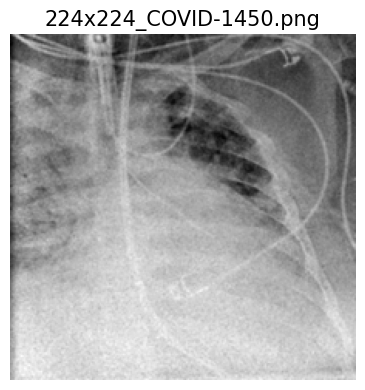


COVID --> Predicted orientation: rotated_180 --> total detected: 4


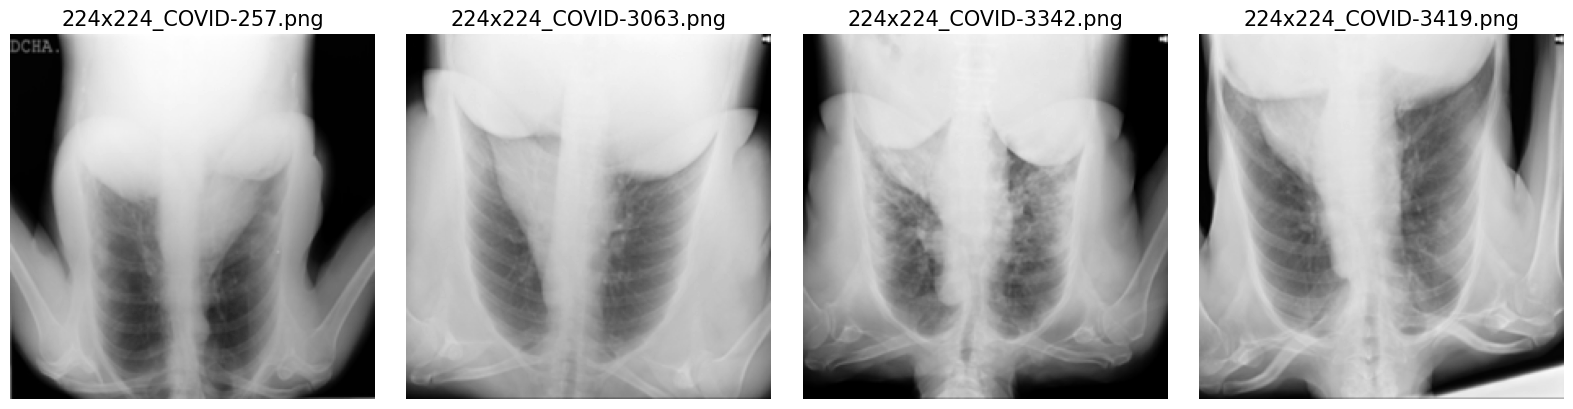


Lung_Opacity --> Predicted orientation: rotated_90 --> total detected: 2


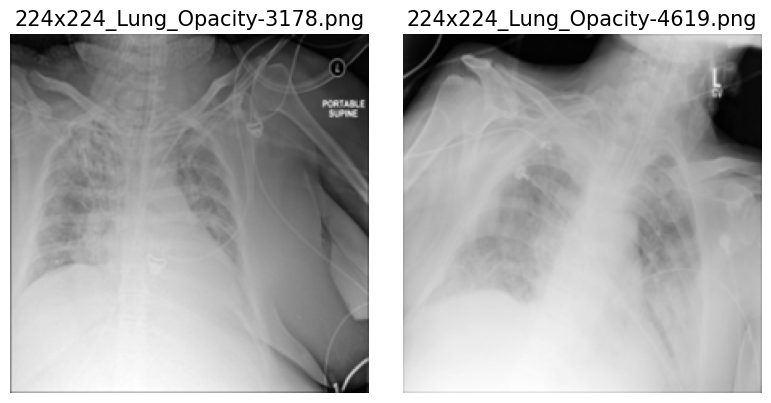


Normal --> Predicted orientation: rotated_minus_90 --> total detected: 2


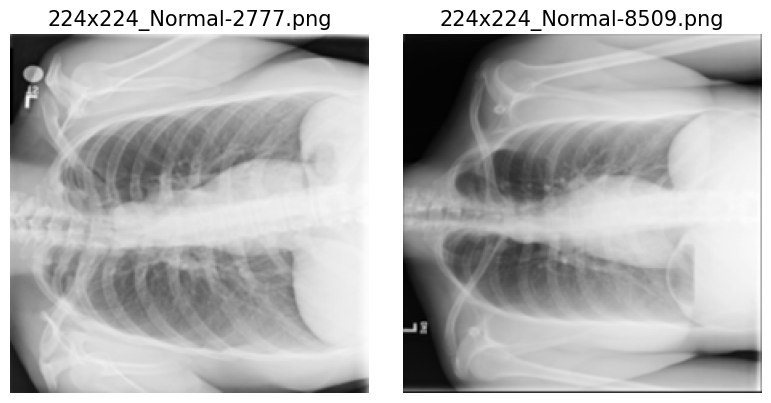

In [4]:
# show rotated_90, rotated_minus_90, rotated_180 images only
def show_rotated_img(dataset):
    
    from src.defs import DiseaseCategory

    df_predicted = None
    dis = None

    for disease in DiseaseCategory:

        if dataset == "test":
            image_dir = r"C:\Users\User\DataScience\area51\data_224x224\224x224_test"
            dis = "test_data"
            df_predicted = loadPredictedData(model_dir, model_prefix, dataset, sort_by=["Disease","Orientation","Confidence"])

            print("This are the images from the test dataset!")
            print(test_dataset_desc)

        elif dataset == "data":
            dis = disease.value
            image_dir = rf"C:\Users\User\DataScience\area51\data\COVID-19_Radiography_Dataset\{dis}\downscaled\224x224"
            df_predicted = loadPredictedData(model_dir, model_prefix, dataset, sort_by=["Disease","Orientation","Confidence"])
        else:
            raise Exception(f"Wrong dataset: {dataset}")
        


        for rot in ("rotated_90", "rotated_minus_90", "rotated_180"):
                        
            i_names = df_predicted["Image"][(df_predicted["Disease"]==dis) & (df_predicted["Orientation"] == rot) ].to_list()
            cnt = len(i_names)
            if len(i_names)>0:
                imgs, img_names = ip.loadImgs(i_names, image_dir)
                print("")
                print(disease.value, f"--> Predicted orientation: {rot}", f"--> total detected: {len(i_names)}")
                ip.plot_images(imgs, img_names, tSize=15, max_img_per_row=5) 


        if dataset == "test":
                break  
        
    return df_predicted
        

df_predicted = show_rotated_img(dataset="data")
#df_predicted = show_rotated_img(dataset="test")



In [57]:
df_predicted.isna().sum()
# df_predicted.where(df_predicted.Confidence < 1, )
df_predicted[df_predicted["Confidence"] < 1].shape  # 19 images
df_predicted[df_predicted["Orientation"] != "correct"]

Image       Orientation  Confidence  \
10833          224x224_COVID-257.png       rotated_180    1.000000   
10834         224x224_COVID-3063.png       rotated_180    1.000000   
10835         224x224_COVID-3342.png       rotated_180    1.000000   
10836         224x224_COVID-3419.png       rotated_180    1.000000   
10837          224x224_COVID-257.png       rotated_180    1.000000   
10838         224x224_COVID-3063.png       rotated_180    1.000000   
10839         224x224_COVID-3342.png       rotated_180    1.000000   
10840         224x224_COVID-3419.png       rotated_180    1.000000   
10841          224x224_COVID-257.png       rotated_180    1.000000   
10842         224x224_COVID-3063.png       rotated_180    1.000000   
10843         224x224_COVID-3342.png       rotated_180    1.000000   
10844         224x224_COVID-3419.png       rotated_180    1.000000   
10845         224x224_COVID-1450.png        rotated_90    0.999999   
10846         224x224_COVID-1450.png        rotated_90    0.999999   
10847         224x224_COVID-1450.png        rotated_90    0.999999   
22868  224x224_Lung_Opacity-3178.png        rotated_90    0.999993   
22869  224x224_Lung_Opacity-3178.png        rotated_90    0.999993   
22870  224x224_Lung_Opacity-4619.png        rotated_90    1.000000   
22871  224x224_Lung_Opacity-4619.png        rotated_90    1.000000   
33062        224x224_Normal-2777.png  rotated_minus_90    1.000000   
33063        224x224_Normal-8509.png  rotated_minus_90    1.000000   

            Disease  
10833         COVID  
10834         COVID  
10835         COVID  
10836         COVID  
10837         COVID  
10838         COVID  
10839         COVID  
10840         COVID  
10841         COVID  
10842         COVID  
10843         COVID  
10844         COVID  
10845         COVID  
10846         COVID  
10847         COVID  
22868  Lung_Opacity  
22869  Lung_Opacity  
22870  Lung_Opacity  
22871  Lung_Opacity  
33062        Normal  
33063        Normal

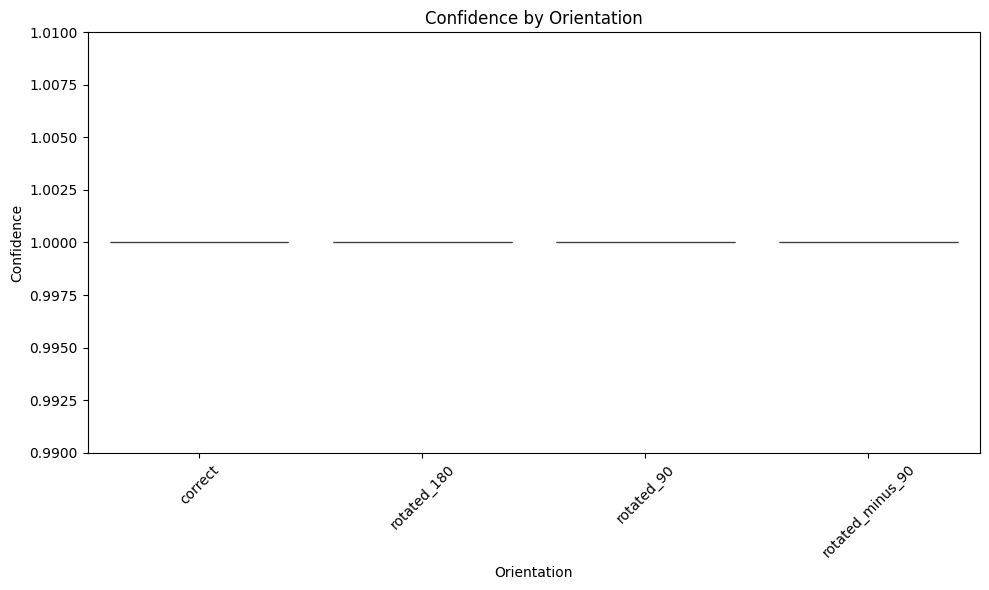

In [24]:
#import sys
#!{sys.executable} -m pip install seaborn

import seaborn as sns

# Create the boxenplot
plt.figure(figsize=(10, 6))
sns.boxenplot(x="Orientation", y="Confidence", data=df_predicted)

# Customize plot
plt.title("Confidence by Orientation")
plt.xlabel("Orientation")
plt.ylabel("Confidence")
plt.ylim(0.99, 1.01)  # Set y-axis limits
plt.xticks(rotation=45)  # Rotate x labels if there are many orientations
plt.tight_layout()
plt.show()